# Camera tracking blue object

Use the provided video or webcam

In [22]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension

You should consider upgrading via the 'c:\users\cheva\anaconda3\python.exe -m pip install --upgrade pip' command.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Fin du code de tracking de base et debut de l'analyse par frame

In [23]:
#le mieux avec un mask bleu
import time
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def frame_analysis_green(fW,fH, frame,gW,gH):

    #Que QR code, a rajouter cadre + depassement 

    cam_grid_ratio = (gW/fW, gH/fH)

    low_green = np.array([36,0,0])
    up_green = np.array([86,255,255])

    low_blue = np.array([110,50,50])
    up_blue = np.array([132,255,255])

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsv, low_green, up_green)
    res = cv2.bitwise_and(frame,frame, mask= mask)

    contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    areas = [cv2.contourArea(c) for c in contours]
    if len(areas) < 5:

            # Display the resulting frame
        x2, y2  = (-1, -1)


    else:

            # Find the largest moving object in the image
        max_index = np.argmax(areas)

        cnt = contours[max_index]

        epsilon = 0.01*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        hull = cv2.convexHull(cnt, returnPoints=False)
            #draw the white contour
        #cv2.drawContours(frame, [approx], -1, (255, 255, 255), 3)

        x,y,w,h = cv2.boundingRect(cnt)
        #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),3)

            # Draw circle in the center of the bounding box
        xf = x + int(w/2)
        yf = y + int(h/2)
        #cv2.circle(frame,(xf,yf),4,(255,255,0),-1)

        x2 = int(xf*cam_grid_ratio[0])
        y2 = gH-int(yf*cam_grid_ratio[1])

        frame = frame[:,:,::-1]
        
    return x2,y2,frame


In [37]:
#open the video and save the frame and return the fW,fH and the frame

def video_handle(filename):
    cap = cv2.VideoCapture(filename)

    fW = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fH = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    low_blue = np.array([110,50,50])
    up_blue = np.array([132,255,255])

    _, frame = cap.read()
    cap.release()
    return fW,fH,frame

In [38]:
def frame_analysis_yellow(fW,fH, frame,gW,gH):

    #Que QR code, a rajouter cadre + depassement 

    cam_grid_ratio = (gW/fW, gH/fH)

    low_yellow = np.array([20, 100, 100])
    up_yellow = np.array([30, 255, 255])
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, low_yellow, up_yellow)
    res = cv2.bitwise_and(frame,frame, mask= mask)

    contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    areas = [cv2.contourArea(c) for c in contours]
    if len(areas) < 5:

        # Display the resulting frame
        x2, y2  = (-1, -1)


    else:

         # Find the largest moving object in the image
        max_index = np.argmax(areas)

        cnt = contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)

         # Draw circle in the center of the bounding box
        xf = x + int(w/2)
        yf = y + int(h/2)
        cv2.circle(frame,(xf,yf),4,(255,255,0),-1)

        x2 = int(xf*cam_grid_ratio[0])
        y2 = gH-int(yf*cam_grid_ratio[1])

        frame = frame[:,:,::-1]
        
    return x2,y2,frame


In [33]:
#detect the green square and gives thymio angle

def give_thymio_angle(image,xcy,ycy,xcg,ycg):
    y1 = ycy
    y2 = ycg
    x1 = xcy
    x2 = xcg

    if xcy > xcg:
        if ycg > ycy:
            angle = math.atan(np.abs(y1-y2)/np.abs(x1-x2))*180/math.pi
        elif ycg == ycy:
            angle = 180
        else:
            angle = -math.atan(np.abs(y1-y2)/np.abs(x1-x2))*180/math.pi

    elif xcy == xcg:
        if ycy > ycg:
            angle = 90 
        else:
            angle = -90
    else: 
        if ycg > ycy:
            angle = math.atan(np.abs(y1-y2)/np.abs(x1-x2))*180/math.pi + 90
        elif ycg == ycy:
            angle = 180
        else:
            angle = math.atan(np.abs(y1-y2)/np.abs(x1-x2))*180/math.pi - 180
            
    return angle


In [34]:
#detect the blue square and resize the frame 

def detect_and_rotate(image):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    #hsv value for the various mask
    low_blue = np.array([110,50,50])
    up_blue = np.array([132,255,255])


    #computing of the blue mask to isolate the contours of the map
    mask_blue = cv2.inRange(hsv, low_blue, up_blue)
    
    #find the outside blue contours of the map on the whole world
    contours, _ = cv2.findContours(mask_blue, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    #find the rectangle which includes the contours
    maxArea = 0
    best = None
    for contour in contours:
      area = cv2.contourArea(contour)
      if area > maxArea :
        maxArea = area
        best = contour

    rect = cv2.minAreaRect(best)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    #crop image inside bounding box
    scale = 1  
    W = rect[1][0]
    H = rect[1][1]

    #finding the box to rotate
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    #finding the rotation angle between vertical and longest size of rectangle
    angle = rect[2]
    rotated = False
    if angle < -45:
        angle += 90
        rotated = True

    #rotation center and rotation matrix
    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(scale*(x2-x1)), int(scale*(y2-y1)))
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    #cropping the image and rotating it
    cropped = cv2.getRectSubPix(image, size, center)
    cropped = cv2.warpAffine(cropped, M, size)
    croppedW = W if not rotated else H
    croppedH = H if not rotated else W

    corrected = cv2.getRectSubPix(cropped, (int(croppedW*scale), int(croppedH*scale)), (size[0]/2, size[1]/2))
    final_grid = np.array(corrected)
    return final_grid

Cellule a exectuer pour tester

==============================

Code pour segmenter une video avec un frame par seconde garder

In [44]:

#def segment_video(videoFile):
imagesFolder = ""
cap = cv2.VideoCapture(0)
frameRate = cap.get(5) # frame rate
numero = 0
while(cap.isOpened()):

    frameId = cap.get(1) # current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename = str(int(numero)) + ".jpg"
        numero = numero + 1
        cv2.imwrite(filename, frame)
    if numero > 30:
        break
cap.release()
    
print("Done!")

Done!


In [18]:
videoFile = "0"#bande.mov"
segment_video(videoFile)

Code to test on the files generated by the code above or pictures !! check le nbr d'image avant de lancer et changer dans le range()

0.jpg


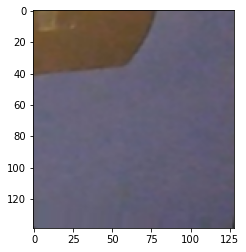

X -1 Y -1
Angle -90
1.jpg


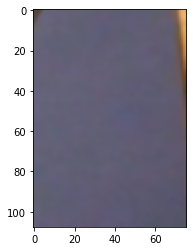

X -1 Y -1
Angle -90
2.jpg


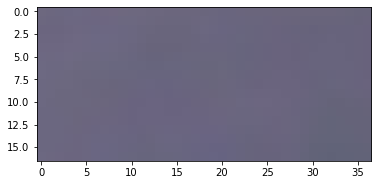

X -1 Y -1
Angle -90
3.jpg


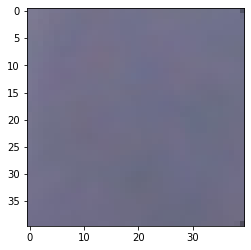

X -1 Y -1
Angle -90
4.jpg


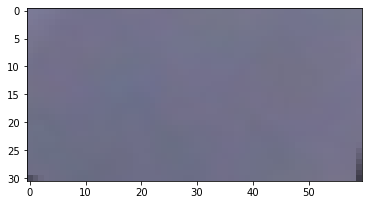

X -1 Y -1
Angle -90
5.jpg


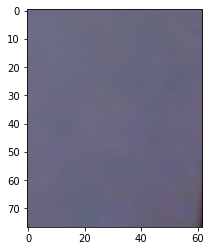

X -1 Y -1
Angle -90
6.jpg


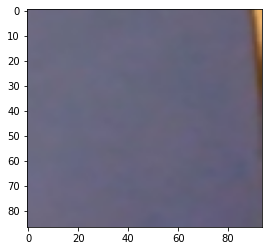

X -1 Y -1
Angle -90
7.jpg


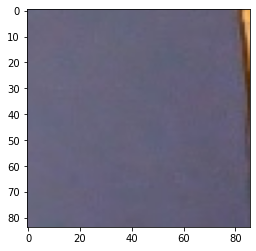

X -1 Y -1
Angle -90
8.jpg


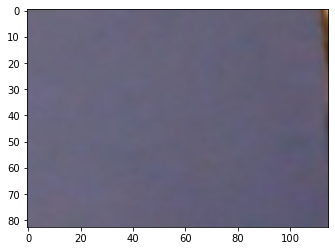

X -1 Y -1
Angle -90
9.jpg


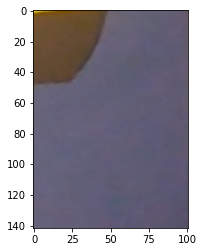

X -1 Y -1
Angle -90
10.jpg


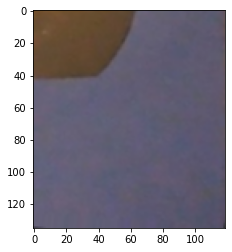

X -1 Y -1
Angle -90
11.jpg


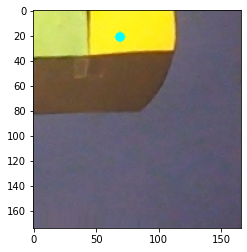

X 9 Y 19
Angle -63.43494882292201
12.jpg


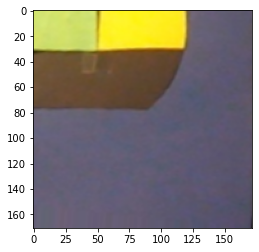

X -1 Y -1
Angle -90
13.jpg


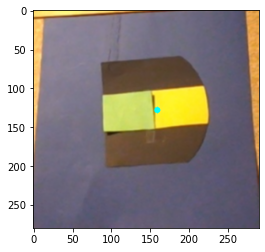

X 12 Y 11
Angle -43.87669728592457
14.jpg


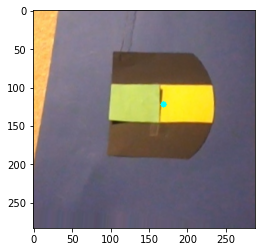

X 21 Y 24
Angle -14.036243467926477
15.jpg


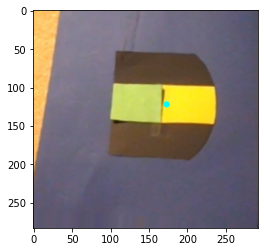

X 13 Y 12
Angle -43.95837332399003
16.jpg


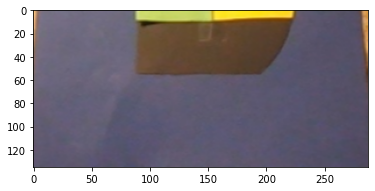

X -1 Y -1
Angle -90
17.jpg


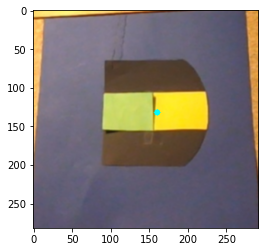

X 24 Y 25
Angle 56.309932474020215
18.jpg


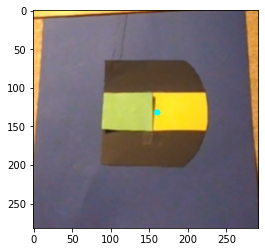

X 12 Y 11
Angle -43.87669728592457
19.jpg


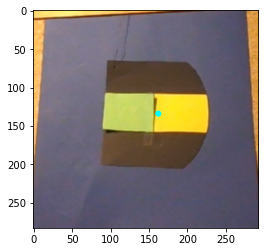

X 12 Y 11
Angle -43.87669728592457
20.jpg


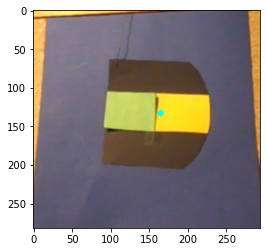

X 12 Y 11
Angle -42.797401838234194
21.jpg


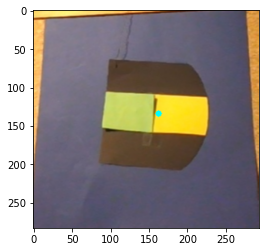

X 20 Y 22
Angle -14.036243467926477
22.jpg


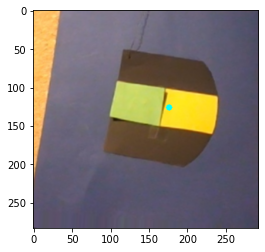

X 21 Y 25
Angle 180
23.jpg


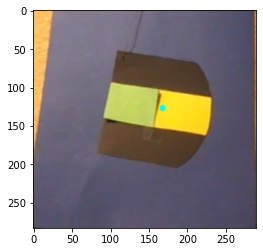

X 13 Y 12
Angle -42.87890360333855
24.jpg


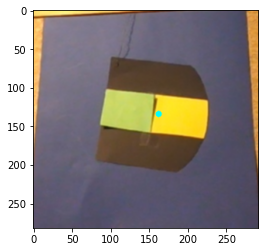

X 24 Y 25
Angle 45.0
25.jpg


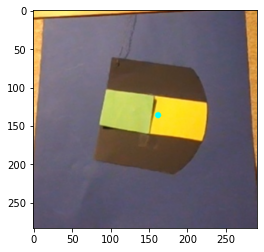

X 12 Y 11
Angle -41.6335393365702
26.jpg


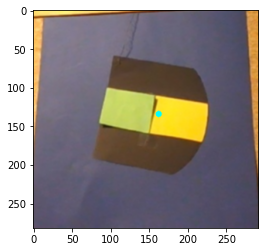

X 12 Y 11
Angle -42.797401838234194
27.jpg


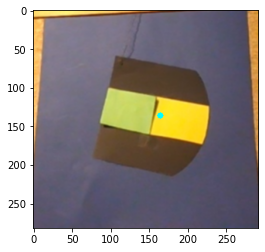

X 12 Y 11
Angle -41.6335393365702
28.jpg


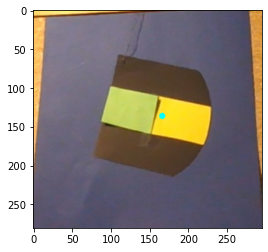

X 12 Y 11
Angle -41.6335393365702
29.jpg


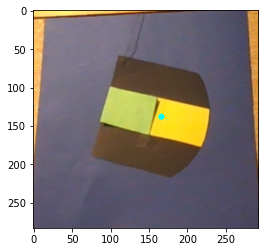

X 12 Y 11
Angle -41.6335393365702
30.jpg


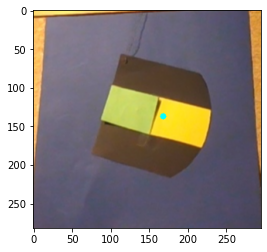

X 12 Y 11
Angle -41.6335393365702


In [45]:
gW = 47 
gH = 44
for numero in range(31):
    filename = str(int(numero)) + ".jpg"
    print(filename)
    frame = cv2.imread(filename)

     #detect the blue square and resize the frame 
    image = detect_and_rotate(frame)
    #find the size of the image for the grid transformation
    fH, fW = image.shape[:2]
    
    #compute the center of the thymio as the middle between yellow and green center
    x2g,y2g,frameg = frame_analysis_green(fW,fH, image,gW,gH)
    x2b,y2b,frameb = frame_analysis_yellow(fW,fH, image,gW,gH)

    #compute thymio angle 
    angle = give_thymio_angle(image,x2b,y2b,x2g,y2g)
    x2 = int((x2g+x2b)/2)
    y2 = int((y2g+y2b)/2)
    

    plt.figure()
    plt.imshow(image[:,:,::-1])
    plt.show()
    
    print('X',x2,'Y',y2)
    print('Angle', angle)


Code pour le projet

In [ ]:
#grid size
gW = 47 
gH = 44

filename = "test_video.mov"

#open the video and save the frame and return the fW,fH and the frame
fW,fH,frame = video_handle(filename)
    
#detect the blue square and resize the frame 
image = detect_and_rotate(frame)

# detect both yellow and green square for further angle and center computation
x2g,y2g,frameg,xcg,ycg = frame_analysis_green(fW,fH, image,gW,gH)
x2y,y2y,framey,xcy,ycy = frame_analysis_yellow(fW,fH, image,gW,gH)

#compute the center of the thymio & gives thymio angle
x2 = (x2g+x2y)/2
y2 = (y2g+y2y)/2
angle = give_thymio_angle(image,xcy,ycy,xcg,ycg)

#plot the image with the drawings and print the X,Y coordinate and the angle
#plt.figure()
#plt.imshow(image[:,:,::-1])
#plt.show()
print('X',x2,'Y',y2)
print('Angle', angle)

In [16]:
#le mieux avec un mask bleu

import cv2
import numpy as np

# i = 0 pour main webcam aka built in, 1 for first usb port etc
#cap = cv2.VideoCapture(i)

cap = cv2.VideoCapture(0)

#cap = cv2.VideoCapture('test.mp4')
#cap = cv2.VideoCapture('test_video.mov')

fW = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fH = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#Que QR code, a rajouter cadre + depassement 
gW = 44 
gH = 42
cam_grid_ratio = (gW/fW, gH/fH)


low_blue = np.array([110,50,50])
up_blue = np.array([132,255,255])
low_green = np.array([36,0,0])
up_green = np.array([86,255,255])
low_red = np.array([178, 179, 0])
up_red = np.array([[255,255,255]])
low_yellow = np.array([20, 100, 100])
up_yellow = np.array([30, 255, 255])

while(1):
    
    _, frame = cap.read()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, low_green, up_green)

    #mask = cv2.inRange(hsv, low_green, up_green)
    resg = cv2.bitwise_and(frame,frame, mask)
    
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    areas = [cv2.contourArea(c) for c in contours]
    if len(areas) < 5:

        # Display the resulting frame
        frame = cv2.resize(frame, (0, 0), None, 1, 1)
        cv2.imshow('frame',frame)
        # If "q" is pressed on the keyboard, exit this loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    else:
        
        # Find the largest moving object in the image
        max_index = np.argmax(areas)
                
        cnt = contours[max_index]
        xg,yg,wg,hg = cv2.boundingRect(cnt)
         
        # Draw circle in the center of the bounding box

        mask = cv2.inRange(hsv, low_yellow, up_yellow)
        resy = cv2.bitwise_and(frame,frame, mask)

        contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        areas = [cv2.contourArea(c) for c in contours]
        if len(areas) < 5:

            # Display the resulting frame
            frame = cv2.resize(frame, (0, 0), None, 1, 1)
            cv2.imshow('frame',frame)
            masky = cv2.inRange(hsv, low_yellow, up_yellow)
            resy = cv2.bitwise_and(frame,frame, masky)
            maskg = cv2.inRange(hsv, low_green, up_green)
            resg = cv2.bitwise_and(frame,frame, maskg)
            cv2.imshow('resg',maskg)
            cv2.imshow('resy', masky)
            
            # If "q" is pressed on the keyboard, exit this loop
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            max_index = np.argmax(areas)      
            cnt = contours[max_index]
            xy,yy,wy,hy = cv2.boundingRect(cnt)

            x2g = xg + int(wg/2)
            y2g = yg + int(hg/2)
            x2y = xy+ int(wy/2)
            y2y = yy+ int(hy/2)        
            #cv2.circle(frame,(x2,y2),4,(255,255,0),-1)
            x2 = int((x2g+x2y)/2)
            y2 = int((y2g+y2y)/2)
            text = "Robot center in map's squares"
            cv2.putText(frame, text, (x2 - 120, y2 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            # int(x2*cam_grid_ratio[0])) is the x value in grid coord
            # gH-int(y2*cam_grid_ratio[1]) is the y value in grid coord
            text2 = "x: " + str(int(x2*cam_grid_ratio[0])) + ", y: " + str(gH-int(y2*cam_grid_ratio[1]))
            cv2.putText(frame, text2, (x2 - 50, y2 + 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

            cv2.circle(frame,(x2,y2),4,(255,255,0),-1)

            #frame = cv2.resize(frame, (0, 0), None, 0.5, 0.5)
            cv2.imshow('frame',frame)
            masky = cv2.inRange(hsv, low_yellow, up_yellow)
            resy = cv2.bitwise_and(frame,frame, masky)
            maskg = cv2.inRange(hsv, low_green, up_green)
            resg = cv2.bitwise_and(frame,frame, maskg)
            cv2.imshow('resg',maskg)
            cv2.imshow('resy', masky)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
cv2.destroyAllWindows()
cap.release()

fin du code follow and compute et apres kalman filter





In [1]:
#predict next value with kalman filter

import cv2 as cv
import numpy as np
import sys

low_green = np.array([36,0,0])
up_green = np.array([86,255,255])

# Instantiate OCV kalman filter
class KalmanFilter:

    kf = cv.KalmanFilter(4, 2)
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)

    def Estimate(self, coordX, coordY):
        ''' This function estimates the position of the object'''
        measured = np.array([[np.float32(coordX)], [np.float32(coordY)]])
        self.kf.correct(measured)
        predicted = self.kf.predict()
        return predicted



#Performs required image processing
class ProcessImage:

    def DetectObject(self):

        cap = cv.VideoCapture(0)

        width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

        # Create Kalman Filter Object
        kfObj = KalmanFilter()
        predictedCoords = np.zeros((2, 1), np.float32)

        while(1):
            rc, frame = cap.read()

            if(rc == True):
                [X, Y] = self.DetectBall(frame)
                if X == -1 and Y == -1:
                    cv.imshow('frame',frame)
                    # If "q" is pressed on the keyboard, exit this loop
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break

                else:    
                    predictedCoords = kfObj.Estimate(X, Y)

                    # Draw Actual coords from segmentation
                    cv.circle(frame, (int(X), int(Y)), 4, (0,0,255), -1)
                    cv.line(frame,(int(X), int(Y)), (int(X + 50), int(Y + 20)), [100,100,255], 2,8)
                    cv.putText(frame, "Actual", (int(X + 50), int(Y + 20)), cv.FONT_HERSHEY_SIMPLEX,0.5, [50,200,250])

                    # Draw Kalman Filter Predicted output
                    cv.circle(frame, (int(predictedCoords[0]), int(predictedCoords[1])), 4, (0,255,255), -1)
                    cv.line(frame, (int(predictedCoords[0]) , int(predictedCoords[1])), (int(predictedCoords[0]) + 50, int(predictedCoords[1]) - 30), [100, 10, 255], 2, 8)
                    cv.putText(frame, "Predicted", (int(predictedCoords[0]) + 50, int(predictedCoords[1]) - 30), cv.FONT_HERSHEY_SIMPLEX, 0.5, [50, 200, 250])
                    cv.imshow('frame', frame)

                    if (cv.waitKey(300) & 0xFF == ord('q')):
                        break

            else:
                break

        cap.release()
        cv.destroyAllWindows()

    # Segment the green ball in a given frame
    def DetectBall(self, frame):

        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        mask = cv.inRange(hsv, low_green, up_green)
        

        # Dilate
        kernel = np.ones((5, 5), np.uint8)
        greenMaskDilated = cv.dilate(mask, kernel)
        contours, hierarchy = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)[-2:]
        areas = [cv.contourArea(c) for c in contours]
        if len(areas) < 1:
            return [-1,-1]
        else:
            max_index = np.argmax(areas)

            cnt = contours[max_index]

            epsilon = 0.01*cv.arcLength(cnt,True)
            approx = cv.approxPolyDP(cnt,epsilon,True)
            hull = cv.convexHull(cnt, returnPoints=False)
            cv.drawContours(frame, [approx], -1, (255, 255, 255), 1)

            x,y,w,h = cv.boundingRect(cnt)
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),3)

            # Draw circle in the center of the bounding box
            X = x + int(w/2)
            Y = y + int(h/2)
            cv.circle(frame,(X,Y),4,(255,255,0),-1)

            return [X, Y]


In [4]:
processImg = ProcessImage()
processImg.DetectObject()